# using opencv


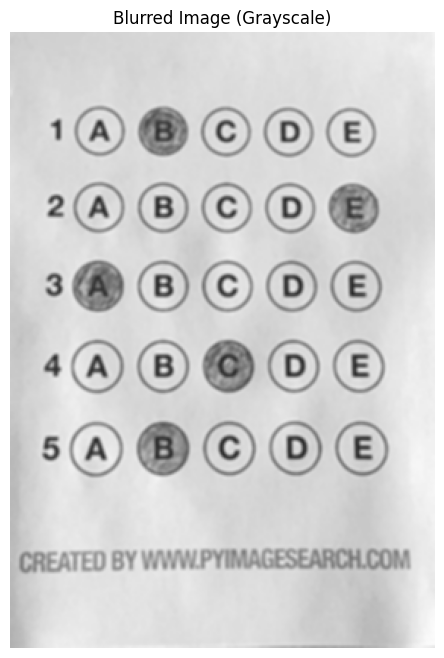

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Function to display images using matplotlib
def display_image(image, title="Image"):
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

# Step 1: Load the image and display the original
image = cv2.imread('omr_test.png')
clone = image.copy()
# Step 2: Convert to grayscale and blur
gray_image = cv2.cvtColor(clone, cv2.COLOR_BGR2GRAY)
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
display_image(blurred_image, "Blurred Image (Grayscale)")


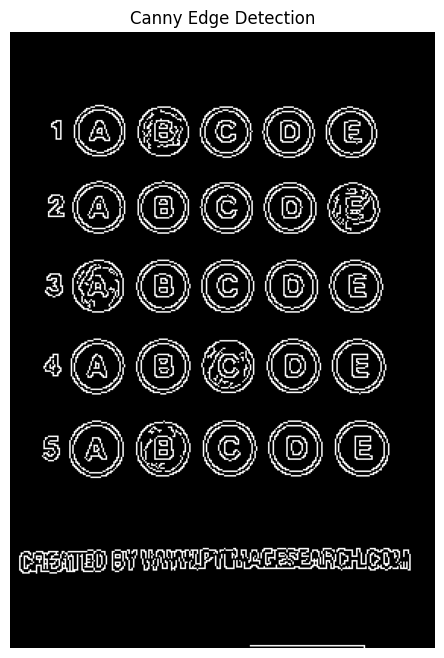

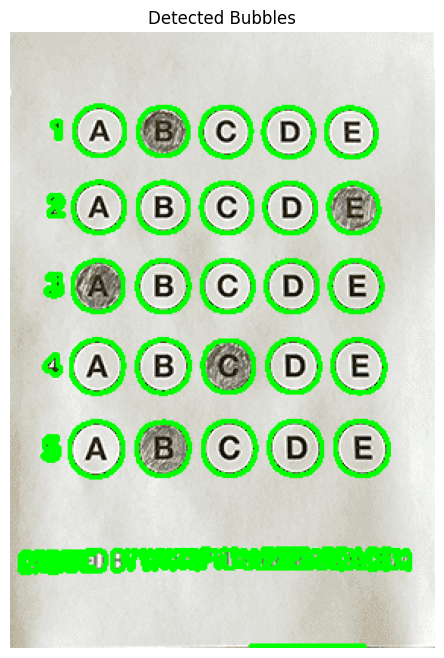

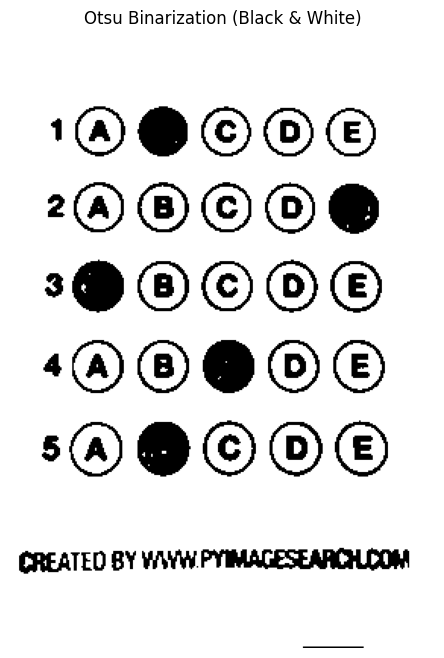

In [2]:


# Step 3: Canny Edge Detection
edges = cv2.Canny(blurred_image, 50, 150)
display_image(edges, "Canny Edge Detection")

# Step 4: Finding Contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 6: Filter contours based on area (size) to detect bubbles
bubble_contours = []
for contour in contours:
    area = cv2.contourArea(contour) 
    bubble_contours.append(contour)

#  Draw the detected bubbles on the original image
output_image = image.copy()
cv2.drawContours(output_image, bubble_contours, -1, (0, 255, 0), 2)
display_image(output_image, "Detected Bubbles")


# Step 6: Binarization using Otsu’s Thresholding
_, otsu_binarized = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
display_image(otsu_binarized, "Otsu Binarization (Black & White)")


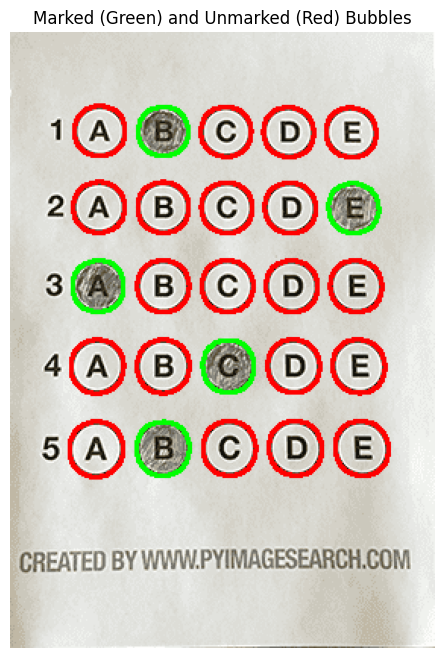

In [13]:
# Step 5: Check for marked or unmarked bubbles
marked_bubbles = []
unmarked_bubbles = []
marked_bubble_array = []

#bubble_contours_sorted = sorted(bubble_contours, key=lambda c: (cv2.boundingRect(c)[1], cv2.boundingRect(c)[0]))


# Updated sorting function
def sort_bubbles(bubble_contours):
    # Get the bounding boxes for the contours
    bounding_boxes = [cv2.boundingRect(c) for c in bubble_contours]
    # Pair each contour with its bounding box
    contours_and_boxes = list(zip(bubble_contours, bounding_boxes))

    # Create a dictionary to store rows based on y-coordinate
    rows = {}
    for contour, (x, y, w, h) in contours_and_boxes:
        # Determine the row based on the y-coordinate
        row_index = y // 60  # You can adjust the divisor based on your bubble spacing
        if row_index not in rows:
            rows[row_index] = []
        rows[row_index].append((contour, (x, y, w, h)))

    # Sort the contours within each row by x-coordinate
    sorted_bubbles = []
    for row_index in sorted(rows.keys()):
        sorted_row = sorted(rows[row_index], key=lambda b: b[1][0])  # Sort by x-coordinate
        sorted_bubbles.extend([c[0] for c in sorted_row])  # Append sorted contours to the final list

    return sorted_bubbles

# Sort bubbles using the new function
bubble_contours_sorted = sort_bubbles(bubble_contours)



for contour in bubble_contours_sorted:
    
    mask = np.zeros_like(gray_image)
    cv2.drawContours(mask, [contour], -1, 255, -1)  

    # Compute the mean pixel intensity within the bubble
    mean_intensity = cv2.mean(otsu_binarized, mask=mask)[0]  

    # Classify as marked (darker bubbles) or unmarked (lighter bubbles)
    if mean_intensity < 100:  
        marked_bubbles.append(contour)
        marked_bubble_array.append(1)
    else:
        unmarked_bubbles.append(contour)
        marked_bubble_array.append(0)
        


output_image = image.copy()
cv2.drawContours(output_image, marked_bubbles, -1, (0, 255, 0), 2)  
cv2.drawContours(output_image, unmarked_bubbles, -1, (0, 0, 255), 2)  
display_image(output_image, "Marked (Green) and Unmarked (Red) Bubbles")

In [14]:
print(marked_bubble_array)

[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]


In [15]:
num_questions = 5
num_choices = 5

correct_answers = [1, 4, 0, 4, 1]  # zero indexed

marks = 0

# Convert the flat array into a list of lists (representing each question's choices)
marked_bubble_matrix = [marked_bubble_array[i:i + num_choices] for i in range(0, len(marked_bubble_array), num_choices)]

# Iterate through each question
for i, row in enumerate(marked_bubble_matrix):
    marked_choice = row.index(1) if 1 in row else -1  # Find the marked choice, if any
    if marked_choice == correct_answers[i]:  # Compare with the correct answer
        marks += 1  # Increment the score if correct

# Print the final marks
print(f"Final Marks: {marks} / {num_questions}")


Final Marks: 4 / 5


## version 2(bubble sorting improved)

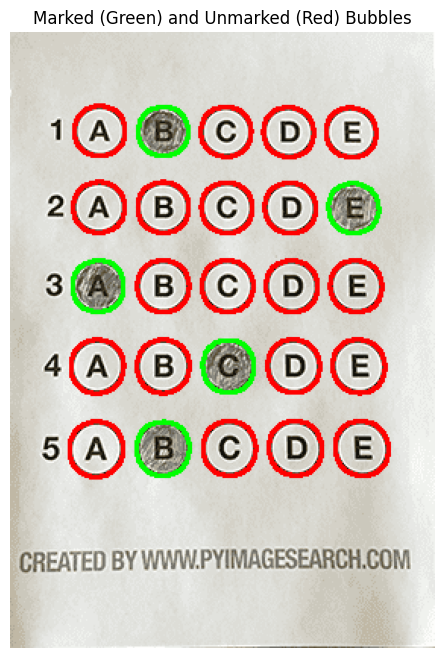

Marked Bubble Matrix (2D):
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 1]
[1, 0, 0, 0, 0]
[0, 0, 1, 0, 0]
[0, 1, 0, 0, 0]
Final Marks: 4 / 5


In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to display images
def display_image(image, title="Image"):
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

# Load and preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    return image, blurred_image

# Perform Canny edge detection
def detect_edges(blurred_image):
    return cv2.Canny(blurred_image, 50, 150)

# Find and filter contours based on area
def find_bubble_contours(edges):
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return [contour for contour in contours if 500 < cv2.contourArea(contour) < 2000]

# Sort bubbles by question (y-axis first, then x-axis)
def sort_bubbles_by_question(bubble_contours, num_choices=5):
    bounding_boxes = [cv2.boundingRect(c) for c in bubble_contours]
    contours_and_boxes = sorted(zip(bubble_contours, bounding_boxes), key=lambda b: b[1][1])
    grouped_contours = [contours_and_boxes[i:i + num_choices] for i in range(0, len(contours_and_boxes), num_choices)]
    sorted_bubbles = [c[0] for group in grouped_contours for c in sorted(group, key=lambda b: b[1][0])]
    return sorted_bubbles

# Perform Otsu’s thresholding
def binarize_image(blurred_image):
    _, otsu_binarized = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return otsu_binarized

# Create the 2D marked bubble array
def create_marked_bubble_array(sorted_bubbles, otsu_binarized, num_questions=5, num_choices=5):
    marked_bubbles=[]
    unmarked_bubbles=[]
    marked_bubble_array = [[0] * num_choices for _ in range(num_questions)]
    for i, contour in enumerate(sorted_bubbles):
        mask = np.zeros_like(otsu_binarized)
        cv2.drawContours(mask, [contour], -1, 255, -1)
        mean_intensity = cv2.mean(otsu_binarized, mask=mask)[0]
        row, col = i // num_choices, i % num_choices
        if mean_intensity < 100:
            marked_bubble_array[row][col] = 1
            marked_bubbles.append(contour)
        else:
            unmarked_bubbles.append(contour)
    output_image = image.copy()
    cv2.drawContours(output_image, marked_bubbles, -1, (0, 255, 0), 2)  # Green for marked bubbles
    cv2.drawContours(output_image, unmarked_bubbles, -1, (0, 0, 255), 2)  # Red for unmarked bubbles
    display_image(output_image, "Marked (Green) and Unmarked (Red) Bubbles")
    return marked_bubble_array

# Calculate final marks based on correct answers
def calculate_marks(marked_bubble_array, correct_answers):
    marks = 0
    for i, row in enumerate(marked_bubble_array):
        marked_choice = row.index(1) if 1 in row else -1
        if marked_choice == correct_answers[i]:
            marks += 1
    return marks


def main(image_path, correct_answers, num_questions=5, num_choices=5):
    image, blurred_image = preprocess_image(image_path)
    edges = detect_edges(blurred_image)
    bubble_contours = find_bubble_contours(edges)
    sorted_bubbles = sort_bubbles_by_question(bubble_contours, num_choices)
    otsu_binarized = binarize_image(blurred_image)
    marked_bubble_array = create_marked_bubble_array(sorted_bubbles, otsu_binarized, num_questions, num_choices)

    print("Marked Bubble Matrix (2D):")
    for row in marked_bubble_array:
        print(row)

    marks = calculate_marks(marked_bubble_array, correct_answers)
    print(f"Final Marks: {marks} / {num_questions}")

    #return image, bubble_contours, marked_bubble_array


image_path = 'omr_test.png'
correct_answers = [1, 4, 0, 4, 1]
main(image_path, correct_answers)


# others


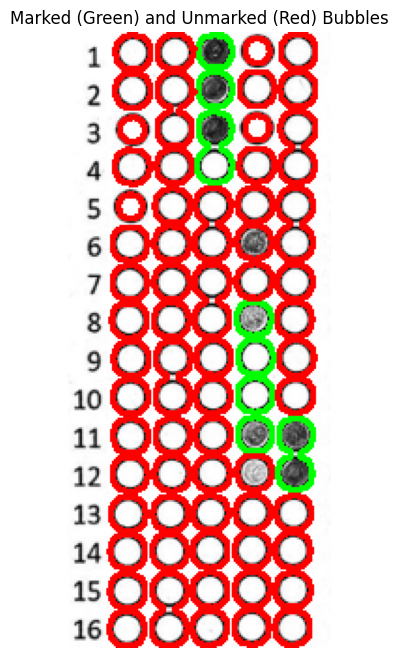

Marked Bubble Array: [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Contour Centroid Coordinates (x, y):
Bubble 1: (34, 10)
Bubble 2: (57, 10)
Bubble 3: (78, 20)
Bubble 4: (101, 9)
Bubble 5: (122, 20)
Bubble 6: (34, 30)
Bubble 7: (57, 40)
Bubble 8: (101, 29)
Bubble 9: (78, 61)
Bubble 10: (122, 60)
Bubble 11: (34, 51)
Bubble 12: (101, 50)
Bubble 13: (34, 71)
Bubble 14: (56, 71)
Bubble 15: (100, 70)
Bubble 16: (55, 92)
Bubble 17: (77, 102)
Bubble 18: (99, 112)
Bubble 19: (121, 102)
Bubble 20: (33, 92)
Bubble 21: (55, 112)
Bubble 22: (33, 123)
Bubble 23: (55, 133)
Bubble 24: (68, 165)
Bubble 25: (121, 153)
Bubble 26: (32, 153)
Bubble 27: (55, 153)
Bubble 28: (99, 163)
Bubble 29: (33, 184)
Bubble 30: (77, 193)
Bubble 31: (99, 203)
Bubble 32: (121, 193)
Bubble 33: (33, 215)
Bubble 34: (56, 215)
Bubble 35: (77, 224)
Bubble 36: (121, 225)
Bubble 37: (33, 235)
Bubble 38: (55, 235)
B

IndexError: list index out of range

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to display images using matplotlib
def display_image(image, title="Image"):
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

# Load the image and display the original
image = cv2.imread('2.png')
clone = image.copy()

# Convert to grayscale and blur
gray_image = cv2.cvtColor(clone, cv2.COLOR_BGR2GRAY)
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

# Canny Edge Detection
edges = cv2.Canny(blurred_image, 50, 150)

# Finding Contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours based on area (size) to detect bubbles
bubble_contours = []
for contour in contours:
    area = cv2.contourArea(contour)
    if 120 < area < 2000:  
        bubble_contours.append(contour)

# Updated sorting function
def sort_bubbles(bubble_contours):
    # Get the bounding boxes for the contours
    bounding_boxes = [cv2.boundingRect(c) for c in bubble_contours]
    # Pair each contour with its bounding box
    contours_and_boxes = list(zip(bubble_contours, bounding_boxes))

    # Create a dictionary to store rows based on y-coordinate
    rows = {}
    for contour, (x, y, w, h) in contours_and_boxes:
        # Determine the row based on the y-coordinate
        row_index = y // 4 # You can adjust the divisor based on your bubble spacing
        if row_index not in rows:
            rows[row_index] = []
        rows[row_index].append((contour, (x, y, w, h)))

    # Sort the contours within each row by x-coordinate
    sorted_bubbles = []
    for row_index in sorted(rows.keys()):
        sorted_row = sorted(rows[row_index], key=lambda b: b[1][0])  # Sort by x-coordinate
        sorted_bubbles.extend([c[0] for c in sorted_row])  # Append sorted contours to the final list

    return sorted_bubbles

# Sort bubbles using the new function
bubble_contours_sorted = sort_bubbles(bubble_contours)

# Binarization using Otsu’s Thresholding
_, otsu_binarized = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Check for marked or unmarked bubbles
marked_bubbles = []
unmarked_bubbles = []
marked_bubble_array = []
centroid_coordinates = []

# Loop over all detected bubble contours
for contour in bubble_contours_sorted:
    # Create a mask for each contour
    mask = np.zeros_like(gray_image)
    cv2.drawContours(mask, [contour], -1, 255, -1)  # Fill the bubble contour on the mask

    # Compute the mean pixel intensity within the bubble
    mean_intensity = cv2.mean(otsu_binarized, mask=mask)[0]  # Mean intensity of the white pixels inside contour

    # Get the centroid of the contour
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroid_coordinates.append((cX, cY))

    # Classify as marked (darker bubbles) or unmarked (lighter bubbles)
    if mean_intensity < 80:  # Threshold value, darker areas are marked
        marked_bubbles.append(contour)
        marked_bubble_array.append(1)  # Marked as 1
    else:
        unmarked_bubbles.append(contour)
        marked_bubble_array.append(0)  # Unmarked as 0

# Draw the results (marked in green, unmarked in red)
output_image = image.copy()
cv2.drawContours(output_image, marked_bubbles, -1, (0, 255, 0), 2)  # Green for marked bubbles
cv2.drawContours(output_image, unmarked_bubbles, -1, (0, 0, 255), 2)  # Red for unmarked bubbles
display_image(output_image, "Marked (Green) and Unmarked (Red) Bubbles")

# Print marked bubble array
print(f"Marked Bubble Array: {marked_bubble_array}")

# Print centroid coordinates
print("Contour Centroid Coordinates (x, y):")
for index, (x, y) in enumerate(centroid_coordinates):
    print(f"Bubble {index + 1}: ({x}, {y})")

# Scoring based on the correct answers
num_questions = 5
num_choices = 5

# Correct answers (zero-indexed, one per question)
correct_answers = [1, 4, 0, 2, 1]

# Initialize marks
marks = 0

# Convert the flat array into a list of lists (representing each question's choices)
marked_bubble_matrix = [marked_bubble_array[i:i + num_choices] for i in range(0, len(marked_bubble_array), num_choices)]

# Iterate through each question to check answers
for i, row in enumerate(marked_bubble_matrix):
    marked_choice = row.index(1) if 1 in row else -1  # Find the marked choice, if any
    if marked_choice == correct_answers[i]:  # Compare with the correct answer
        marks += 1  # Increment the score if correct

# Print the final marks
print(f"Final Marks: {marks} / {num_questions}")


# testing with the template

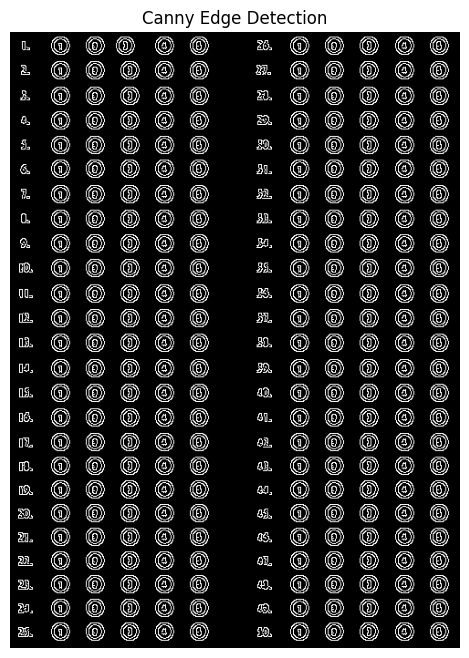

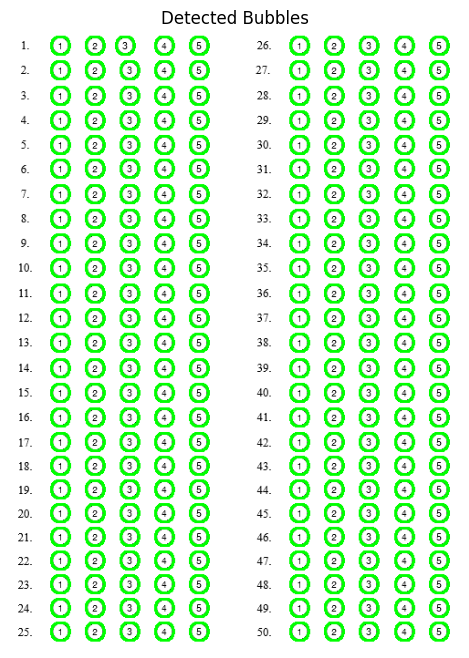

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to display images
def display_image(image, title="Image"):
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

# Step 1: Load the image and display the original
image = cv2.imread('withoutborder50.png')
clone = image.copy()
# Step 2: Convert to grayscale and blur
gray_image = cv2.cvtColor(clone, cv2.COLOR_BGR2GRAY)
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

# Step 3: Canny Edge Detection
edges = cv2.Canny(blurred_image, 50, 150)
display_image(edges, "Canny Edge Detection")

# Step 4: Finding Contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 6: Filter contours based on area (size) to detect bubbles
bubble_contours = []
for contour in contours:
    area = cv2.contourArea(contour) 
    if area > 200 and area < 2000:
        bubble_contours.append(contour)

#  Draw the detected bubbles on the original image
output_image = image.copy()
cv2.drawContours(output_image, bubble_contours, -1, (0, 255, 0), 2)
display_image(output_image, "Detected Bubbles")

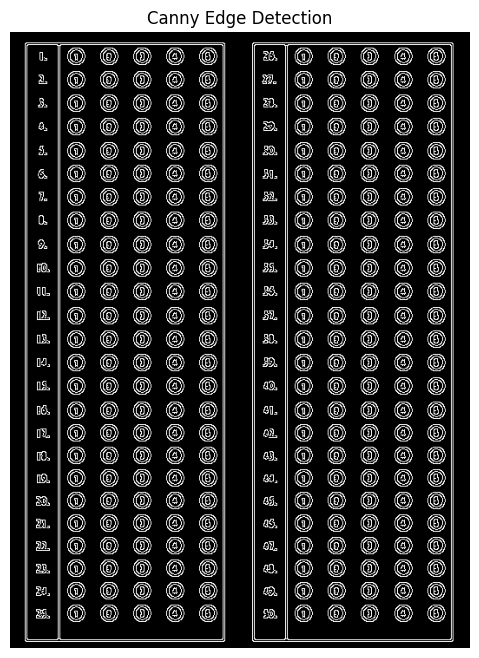

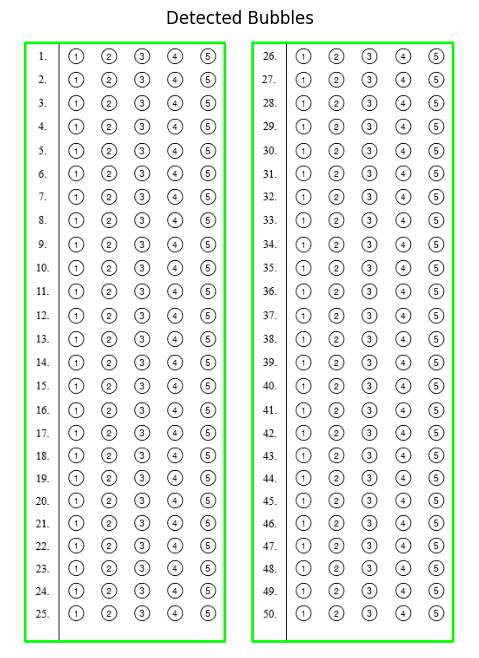

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to display images
def display_image(image, title="Image"):
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

# Step 1: Load the image and display the original
image = cv2.imread('border50.png')
clone = image.copy()
# Step 2: Convert to grayscale and blur
gray_image = cv2.cvtColor(clone, cv2.COLOR_BGR2GRAY)
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

# Step 3: Canny Edge Detection
edges = cv2.Canny(blurred_image, 50, 150)
display_image(edges, "Canny Edge Detection")

# Step 4: Finding Contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 6: Filter contours based on area (size) to detect bubbles
bubble_contours = []
for contour in contours:
    area = cv2.contourArea(contour) 
    bubble_contours.append(contour)

#  Draw the detected bubbles on the original image
output_image = image.copy()
cv2.drawContours(output_image, bubble_contours, -1, (0, 255, 0), 2)
display_image(output_image, "Detected Bubbles")

# Perspective view

In [16]:
import cv2
import numpy as np

def correct_perspective(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Use Canny edge detection to find edges
    edges = cv2.Canny(gray, 50, 150)
    
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cv2.drawContours(image, contours, -1, (0, 255, 0), 2)
    display_image(image, "Contours")

    
    # Sort contours by area and take the largest one (assuming it's the paper)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    paper_contour = contours[0]
    
    # Approximate the contour to get the four corners
    epsilon = 0.02 * cv2.arcLength(paper_contour, True)
    approx = cv2.approxPolyDP(paper_contour, epsilon, True)
    
    # Check if we have exactly four corners
    if len(approx) != 4:
        raise ValueError("Paper contour could not be detected with four corners")
    
    # Sort points in a consistent order: top-left, top-right, bottom-right, bottom-left
    points = np.array([point[0] for point in approx])
    s = points.sum(axis=1)
    diff = np.diff(points, axis=1)
    
    rect = np.zeros((4, 2), dtype="float32")
    rect[0] = points[np.argmin(s)]       # top-left
    rect[2] = points[np.argmax(s)]       # bottom-right
    rect[1] = points[np.argmin(diff)]    # top-right
    rect[3] = points[np.argmax(diff)]    # bottom-left
    
    # Calculate the width and height of the new image
    width = max(np.linalg.norm(rect[0] - rect[1]), np.linalg.norm(rect[2] - rect[3]))
    height = max(np.linalg.norm(rect[0] - rect[3]), np.linalg.norm(rect[1] - rect[2]))
    
    # Define destination points for the top-down view
    destination = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype="float32")
    
    # Get the perspective transform matrix and apply it
    matrix = cv2.getPerspectiveTransform(rect, destination)
    warped = cv2.warpPerspective(image, matrix, (int(width), int(height)))
    
    return warped


In [17]:
def crop_paper(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Use Canny edge detection to find edges
    edges = cv2.Canny(gray, 50, 150)
    
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sort contours by area and take the largest one (assuming it's the paper)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    paper_contour = contours[0]
    
    # Get bounding rectangle for the paper
    x, y, w, h = cv2.boundingRect(paper_contour)
    
    # Crop the image to this bounding rectangle
    cropped = image[y:y + h, x:x + w]
    
    return cropped


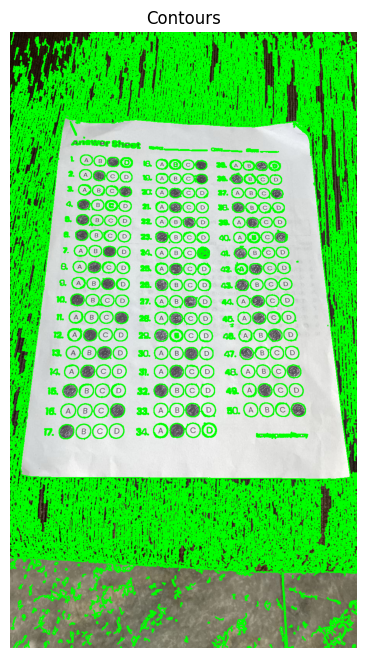

ValueError: Paper contour could not be detected with four corners

In [18]:
# Load your image
image = cv2.imread('./Test/per.jpg')

# Step 1: Correct perspective to get a top-down view
top_view = correct_perspective(image)

# Step 2: Crop the paper part from the top-down view
cropped_paper = crop_paper(image)

# Display or save the result
cv2.imshow("Cropped Paper", cropped_paper)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [15]:
import matplotlib.pyplot as plt
def display_image(image, title="Image"):
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()


In [ ]:
import cv2
from operator import itemgetter
from glob import glob
import matplotlib.pyplot as plt
paper = cv2.imread('./Test/per.jpg')
# Coordinates that you want to Perspective Transform
pts1 = np.float32([[219,209],[612,8],[380,493],[785,271]])
# Size of the Transformed Image
pts2 = np.float32([[0,0],[500,0],[0,400],[500,400]])
for val in pts1:
    cv2.circle(paper,(val[0],val[1]),5,(0,255,0),-1)
M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(paper,M,(500,400))
plt.imshow(dst)

NameError: name 'pt1' is not defined

In [ ]:

import os
import mimetypes
import requests

API_BASE = "https://4kung61e41.execute-api.ap-south-1.amazonaws.com/TestStage"



def get_presigned_upload_url(file_extension, exam_id, student_id):
    """
    POST /generate_presigned_url/upload
    """
    url = f"{API_BASE}/generate_presigned_url/upload"
    payload = {
        "file_type": "reference_paper",
        "file_extension": file_extension,
        "exam_id": exam_id,
        "student_id": student_id
    }
    resp = requests.post(url, json=payload)
    resp.raise_for_status()
    data = resp.json()
    return data["upload_url"], data["file_name"]

def upload_file_to_s3(upload_url, file_path):
    """
    PUT the file bytes to the presigned S3 URL.
    """
    content_type = mimetypes.guess_type(file_path)[0] or "application/octet-stream"
    headers = {"Content-Type": content_type}
    with open(file_path, "rb") as f:
        resp = requests.put(upload_url, data=f, headers=headers)
    resp.raise_for_status()
    return resp.status_code

def get_presigned_download_url(file_name):
    """
    GET /generate_presigned_url/download?file_name=...
    """
    url = f"{API_BASE}/generate_presigned_url/download"
    params = {"file_name": file_name}
    resp = requests.get(url, params=params)
    resp.raise_for_status()
    data = resp.json()
    return data["download_url"]

def verify_upload(download_url):
    """
    Simple GET to confirm the file is retrievable.
    """
    resp = requests.get(download_url)
    return resp.status_code == 200 and bool(resp.content)


In [ ]:

file_path  = ""   
exam_id    = "80"                                 
student_id = "4"                                  
# sanity check
if not os.path.isfile(file_path):
    raise FileNotFoundError(f"{file_path} does not exist")

In [ ]:
status = upload_file_to_s3(upload_url, file_path)
print("Upload HTTP status:", status)